In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Virtual memory usage - total: 31 GB / available: 22 GB / percent used: 27.2 %


In [2]:
# Open a dataset with monthly data
ds = xr.open_dataset(
    'snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [3]:
# Get the variable and perdiod
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Make month weights
http://xarray.pydata.org/en/stable/examples/monthly-means.html  
(bug leap year fixed: https://github.com/pydata/xarray/pull/3464)

In [4]:
# Days per month for different calendar types
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [5]:
# Deal with leap years
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [6]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar='gregorian'),
                            coords=[da.time], name='month_length')
month_length

<xarray.DataArray 'month_length' (time: 372)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,

In [7]:
# Check leap year
import calendar

year = 2000

print(calendar.isleap(year))
month_length.sel(time=str(year))

True


<xarray.DataArray 'month_length' (time: 12)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01

## Annual cycle

### Compute the weights

In [8]:
calendar='standard'

In [9]:
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar=calendar), coords=[da.time], name='month_length')
month_length

<xarray.DataArray 'month_length' (time: 372)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,

In [10]:
normalize = month_length.astype(float).groupby('time.month').sum()
normalize

<xarray.DataArray 'month_length' (month: 12)>
array([961., 876., 961., 930., 961., 930., 961., 961., 930., 961., 930.,
       961.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [11]:
# All months have same weights except for February where the leap years have a slight stronger weight
# Be aware that the weights are grouped by month
weights = month_length.groupby('time.month') / normalize
weights.head(24)

<xarray.DataArray 'month_length' (time: 24)>
array([0.03225806, 0.03310502, 0.03225806, 0.03225806, 0.03225806,
       0.03225806, 0.03225806, 0.03225806, 0.03225806, 0.03225806,
       0.03225806, 0.03225806, 0.03225806, 0.03196347, 0.03225806,
       0.03225806, 0.03225806, 0.03225806, 0.03225806, 0.03225806,
       0.03225806, 0.03225806, 0.03225806, 0.03225806])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 1985-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12

In [12]:
np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))
annual_cycle_weighted = (da * weights).groupby('time.month').sum(dim='time', skipna=False)
annual_cycle_weighted

<xarray.DataArray (month: 12, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 10

### Compute the annual cycle not weighted

In [13]:
annual_cycle_not_weighted = da.groupby('time.month').mean('time', skipna=False)

<IPython.core.display.Javascript object>


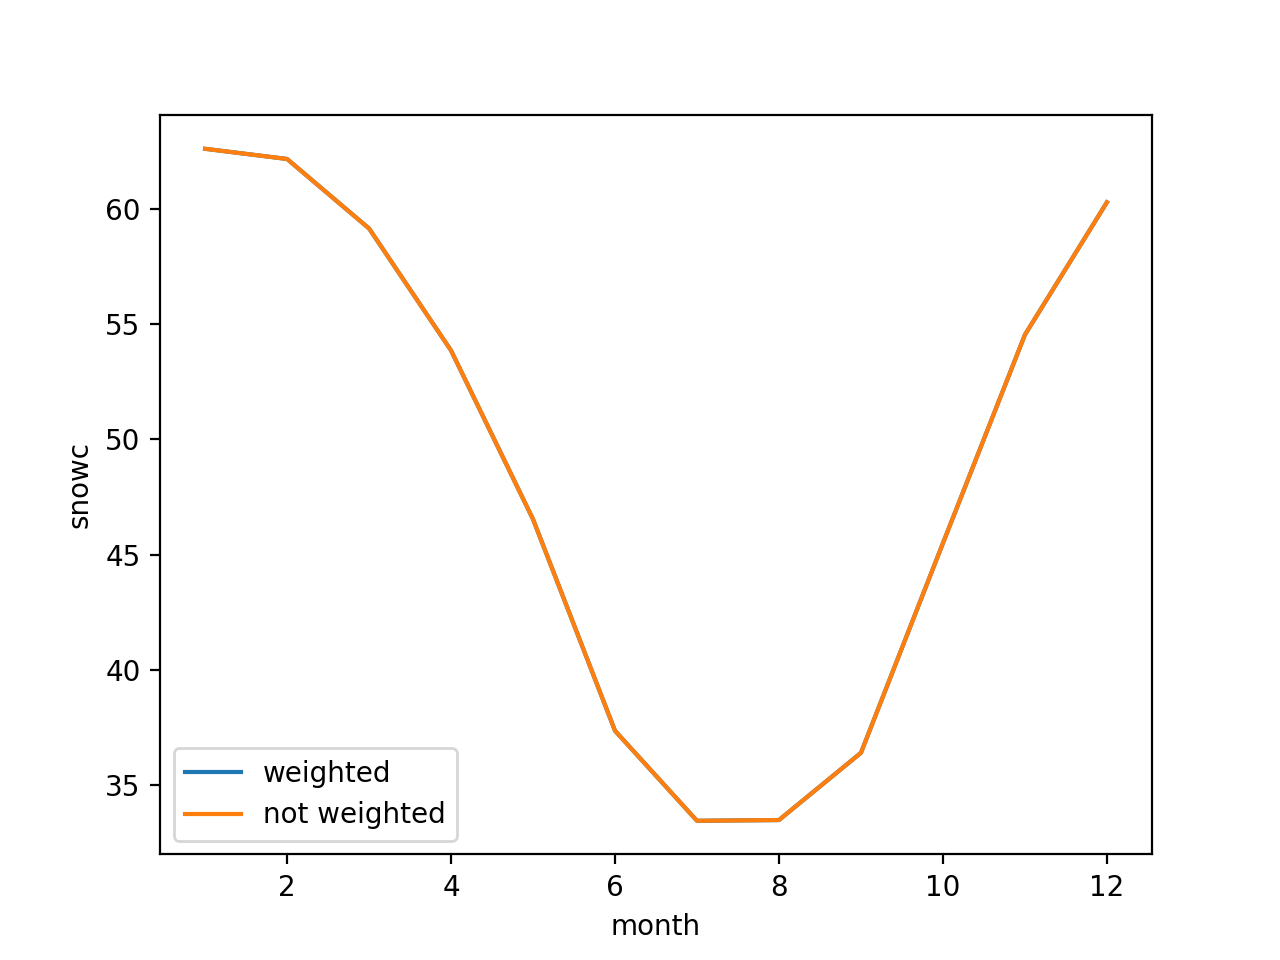

In [14]:
plt.figure()
annual_cycle_weighted.mean(dim=('lat','lon')).plot(label='weighted')
annual_cycle_not_weighted.mean(dim=('lat','lon')).plot(label='not weighted')
plt.legend()

In [30]:
# Difference at 1e-3 on a spatial average for February
annual_cycle_weighted.mean(dim=('lat','lon')) - annual_cycle_not_weighted.mean(dim=('lat','lon'))

<xarray.DataArray (month: 12)>
array([ 1.19094238e-06,  1.73536681e-03,  3.98337423e-06, -1.66993881e-06,
       -4.66988887e-07, -3.76844234e-07, -1.56802319e-06, -2.83646548e-06,
       -1.89353334e-06,  2.75990865e-06, -1.27420719e-07,  6.04913424e-07])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

# Check with utils.annual_cycle

In [15]:
annual_cycle = u.annual_cycle(da, calendar='gregorian')
annual_cycle

<xarray.DataArray (month: 12, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 10

In [16]:
# Weighted annual cycle check
annual_cycle_weighted.mean(dim=('lat','lon')) - annual_cycle.mean(dim=('lat','lon'))

<xarray.DataArray (month: 12)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
# Not weighted annual cycle check
annual_cycle = u.annual_cycle(da, calendar='360_day')
annual_cycle_not_weighted.mean(dim=('lat','lon')) - annual_cycle.mean(dim=('lat','lon'))

<xarray.DataArray (month: 12)>
array([-1.19094238e-06, -4.59275246e-06, -3.98337423e-06,  1.66993881e-06,
        4.66988887e-07,  3.76844234e-07,  1.56802319e-06,  2.83646548e-06,
        1.89353334e-06, -2.75990865e-06,  1.27420719e-07, -6.04913424e-07])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

# Check with CDO

In [18]:
!cdo ymonavg snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc snowc.ymonavg.noaaV2c_198401_201412_2.0x1.75.nc

cdo ymonavg: Processed 6714600 values from 2 variables over 372 timesteps [0.11s 61MB]


In [19]:
ymonavg = xr.open_dataset('snowc.ymonavg.noaaV2c_198401_201412_2.0x1.75.nc').snowc
ymonavg

<xarray.DataArray 'snowc' (time: 12, lat: 94, lon: 192)>
[216576 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actu

In [20]:
ymonavg.mean(dim=('lat','lon')).values - annual_cycle_not_weighted.mean(dim=('lat','lon')).values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)